# More Multivariate Normal Things


## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats

In [49]:
df1 = pd.read_csv('breast-cancer.csv')
# Target: 
# M - Malignant (cancerous)
# B - Benign (non-cancerous)

In [46]:
#df1.head()

In [47]:
#list(df1.columns.values)

In [50]:
df1['diagnosis'] = df1['diagnosis'].map({'M': 1, 'B': 0})
df1.dropna(subset=['diagnosis'], inplace=True)

reduced_features = ['radius_mean', 'texture_mean', 'smoothness_mean', 
                    'compactness_mean', 'concave points_mean', 'symmetry_mean', 
                    'fractal_dimension_mean']

X = df1[reduced_features].values # standardize
means = X.mean(axis=0)
stds = X.std(axis=0)
X = (X - means) / stds  
y = df1['diagnosis'].values  

In [51]:
with pm.Model() as logistic_model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    logits = intercept + pm.math.dot(X, betas)
    
    y_obs = pm.Bernoulli('y_obs', logit_p=logits, observed=y)
    
    trace = pm.sample(target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [52]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],2.467,0.526,1.531,3.493,0.010,0.007,2926.0,2961.0,1.0
betas[1],1.380,0.218,0.931,1.747,0.004,0.003,3450.0,2953.0,1.0
betas[2],0.611,0.306,0.055,1.200,0.005,0.005,3507.0,2899.0,1.0
betas[3],0.076,0.503,-0.838,1.038,0.009,0.007,2973.0,2651.0,1.0
betas[4],2.644,0.577,1.641,3.815,0.010,0.011,3482.0,2677.0,1.0
betas[5],0.448,0.255,-0.028,0.925,0.004,0.004,4383.0,3263.0,1.0
betas[6],-0.328,0.397,-1.061,0.420,0.007,0.006,2850.0,2771.0,1.0
intercept,-0.736,0.204,-1.098,-0.340,0.004,0.003,3194.0,2802.0,1.0


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

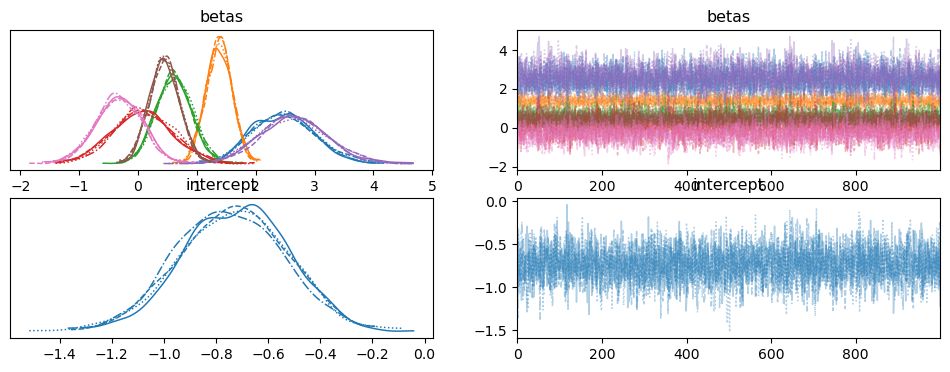

In [53]:
az.plot_trace(trace)

### Provide inference with Bayesian posterior analysis and report MCMC diagnostics

target: diagnosis (1 (cancerous) or 0 (non-cancerous))
predictors: 
* betas[0]: 'radius_mean'
* betas[1]: 'texture_mean'
* betas[2]: 'smoothness_mean'
* betas[3]: 'compactness_mean'
* betas[4]: 'concave points_mean'
* betas[5]: 'symmetry_mean'
* betas[6]: 'fractal_dimension_mean'

predictors
* betas[0] (2.467) and betas[4] (2.644) have the largest positive impact
* betas[1] (1.380) and betas[2] (0.611) also have some impact
* betas[3], betas[5], and betas[6] have minimal effect and the HDI includes zero - indicates uncertainty

intercept
* negative intercept=-0.736 suggests without any predictors the chance of presence of cancer is low

SD
* most predictors have SDs between 0.2 and 0.5 indicating moderate variability

MCMC
* r_hat = 1.0 indicates all chains have converged
* ESS values are >2500 high - posterior is well sampled
* low MCSE values (around 0) suggetst stable parameter estimates

# Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [3]:
df2 = pd.read_csv('austin_weather.csv')

In [54]:
#df2.head()

In [55]:
#list(df2.columns.values)

# Set 0

In [33]:
predictors = ['DewPointAvgF', 'WindAvgMPH', 'SeaLevelPressureAvgInches']
targets = ['TempHighF', 'TempAvgF', 'TempLowF']

df2 = df2.dropna(subset=predictors + targets)

df2[predictors + targets] = df2[predictors + targets].apply(pd.to_numeric, errors='coerce')
X = df2[predictors].values.astype(float)  # Shape: (n, p)
y = df2[targets].values.astype(float)  # Shape: (n, m)

n = 20
p = X.shape[1] #p=3
m = y.shape[1] #m=3

X, y = X[:n, :], y[:n, :]

X = X - X.mean(axis=0)

a_cov = np.cov(y.T)  

In [34]:
with pm.Model() as MNV_LKJ:

    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    y_obs = pm.MvNormal('y', mu=X @ betas, chol=L, observed=y)

    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2988 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",774.234,98.567,588.024,958.719,2.284,1.759,1906.0,2137.0,1.0
"Sigma[0, 1]",619.189,78.538,472.331,767.909,1.865,1.463,1817.0,2013.0,1.0
"Sigma[0, 2]",459.561,60.047,351.380,574.838,1.457,1.166,1735.0,1970.0,1.0
"Sigma[1, 0]",619.189,78.538,472.331,767.909,1.865,1.463,1817.0,2013.0,1.0
"Sigma[1, 1]",505.833,63.570,387.065,622.869,1.523,1.202,1783.0,2016.0,1.0
"Sigma[1, 2]",387.150,49.330,296.661,480.882,1.178,0.927,1793.0,1965.0,1.0
"Sigma[2, 0]",459.561,60.047,351.380,574.838,1.457,1.166,1735.0,1970.0,1.0
"Sigma[2, 1]",387.150,49.330,296.661,480.882,1.178,0.927,1793.0,1965.0,1.0
"Sigma[2, 2]",309.153,39.722,241.912,388.424,0.917,0.694,1919.0,2325.0,1.0
"betas[0, 0]",0.363,0.426,-0.429,1.177,0.009,0.007,2364.0,2417.0,1.0


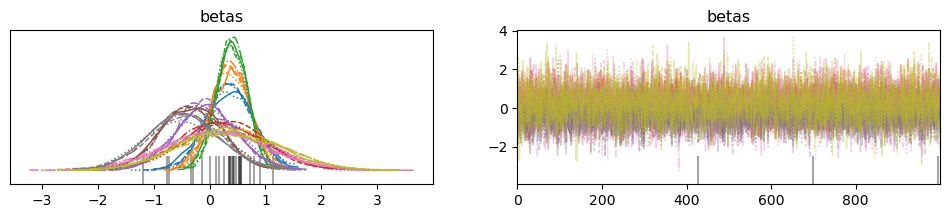

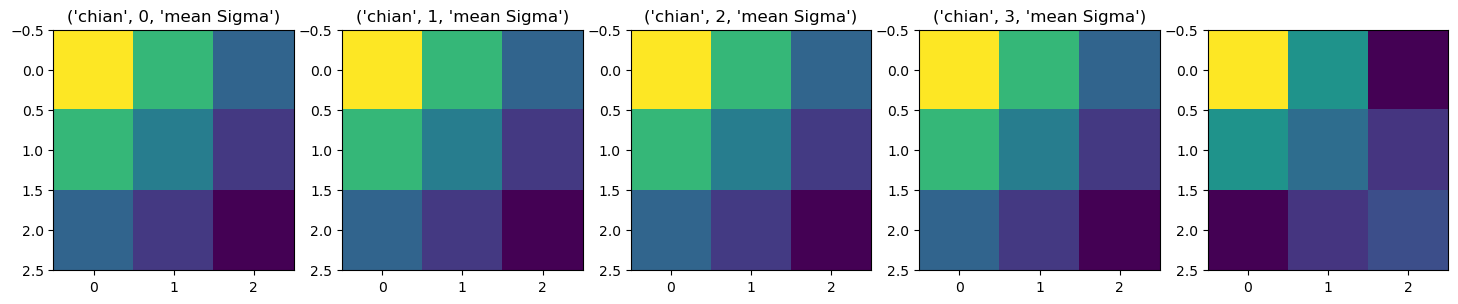

In [36]:
az.plot_trace(idata,var_names='betas');
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))

# Set 1

In [42]:
predictors1 = ['DewPointAvgF', 'WindAvgMPH']
targets1 = ['TempHighF', 'TempLowF']

df2 = df2.dropna(subset=predictors1 + targets1)

df2[predictors1 + targets1] = df2[predictors1 + targets1].apply(pd.to_numeric, errors='coerce')
X1 = df2[predictors1].values.astype(float)  # Shape: (n, p)
y1 = df2[targets1].values.astype(float)  # Shape: (n, m)

n1 = 30
p1 = X1.shape[1] #p=2
m1 = y1.shape[1] #m=2

X1, y1 = X1[:n1, :], y1[:n1, :]

X1 = X1 - X1.mean(axis=0)
a_cov1 = np.cov(1y.T)

with pm.Model() as MNV_LKJ1:

    packed_L = pm.LKJCholeskyCov("packed_L", n=m1, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m1), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m1, packed_L)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p1, m1))
    
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    y_obs = pm.MvNormal('y1', mu=X1 @ betas, chol=L, observed=y1)

    idata1 = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 134 seconds.


In [43]:
az.summary(idata1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",993.939,143.226,737.548,1260.450,2.920,2.482,2474.0,2588.0,1.0
"Sigma[0, 1]",600.735,87.846,443.096,766.344,1.829,1.589,2377.0,2326.0,1.0
"Sigma[1, 0]",600.735,87.846,443.096,766.344,1.829,1.589,2377.0,2326.0,1.0
"Sigma[1, 1]",395.109,58.021,296.720,506.654,1.185,1.022,2466.0,2418.0,1.0
"betas[0, 0]",0.402,0.504,-0.483,1.407,0.011,0.009,2035.0,2278.0,1.0
"betas[0, 1]",0.422,0.321,-0.183,1.013,0.007,0.006,2040.0,2122.0,1.0
"betas[1, 0]",0.220,0.849,-1.371,1.790,0.016,0.013,2911.0,2658.0,1.0
"betas[1, 1]",-0.356,0.617,-1.540,0.807,0.012,0.010,2594.0,2418.0,1.0
packed_L[0],31.446,2.252,27.158,35.503,0.046,0.037,2474.0,2588.0,1.0
packed_L[1],19.010,1.489,16.266,21.752,0.030,0.025,2422.0,2481.0,1.0


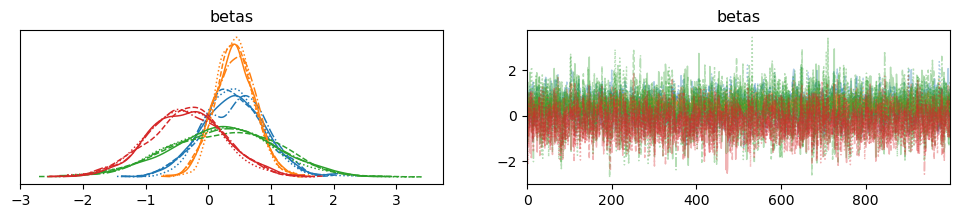

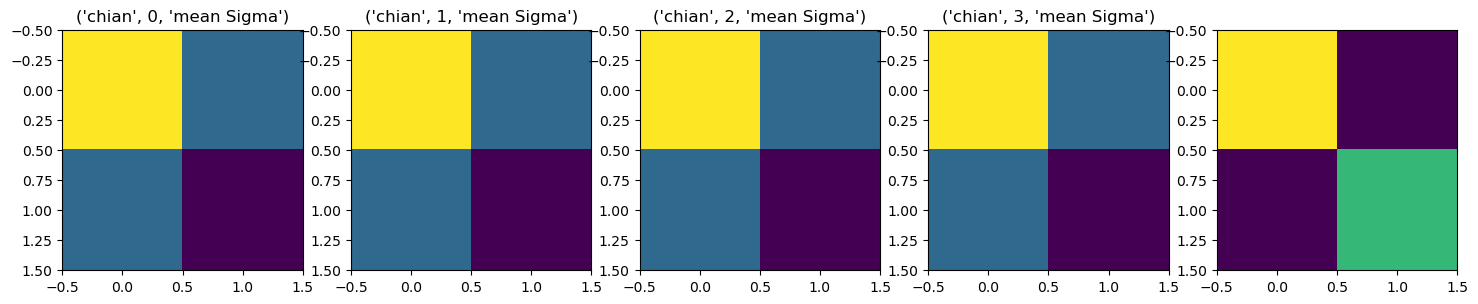

In [45]:
az.plot_trace(idata1,var_names='betas');
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov1)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata1.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))

# Set 2

In [29]:
predictors2 = ['DewPointAvgF']
targets2 = ['TempHighF', 'TempLowF']

df2 = df2.dropna(subset=predictors2 + targets2)

df2[predictors2 + targets2] = df2[predictors2 + targets2].apply(pd.to_numeric, errors='coerce')
X2 = df2[predictors2].values.astype(float)  # Shape: (n, p)
y2 = df2[targets2].values.astype(float)  # Shape: (n, m)

n2 = 20
p2 = X2.shape[1] #p=1
m2 = y2.shape[1] #m=2

X2, y2 = X2[:n2, :], y2[:n2, :]

X2 = X2 - X2.mean(axis=0)

a_cov2 = np.cov(y2.T) 


with pm.Model() as MNV_LKJ2:

    packed_L = pm.LKJCholeskyCov("packed_L", n=m2, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m2), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m2, packed_L)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p2, m2))
    
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    y_obs = pm.MvNormal('y2', mu=X2 @ betas, chol=L, observed=y2)

    idata2 = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.


In [32]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",998.126,141.174,758.523,1280.944,3.296,2.427,1930.0,2337.0,1.0
"Sigma[0, 1]",602.375,86.172,445.313,763.457,2.046,1.512,1867.0,2049.0,1.0
"Sigma[1, 0]",602.375,86.172,445.313,763.457,2.046,1.512,1867.0,2049.0,1.0
"Sigma[1, 1]",396.385,56.130,301.558,507.536,1.335,0.955,1861.0,2078.0,1.0
"betas[0, 0]",0.385,0.489,-0.487,1.315,0.011,0.009,1901.0,1777.0,1.0
"betas[0, 1]",0.440,0.312,-0.137,1.026,0.007,0.006,1920.0,1902.0,1.0
packed_L[0],31.515,2.214,27.541,35.790,0.051,0.036,1930.0,2337.0,1.0
packed_L[1],19.024,1.457,16.343,21.791,0.034,0.023,1896.0,2198.0,1.0
packed_L[2],5.591,1.041,3.828,7.522,0.023,0.023,2229.0,2208.0,1.0


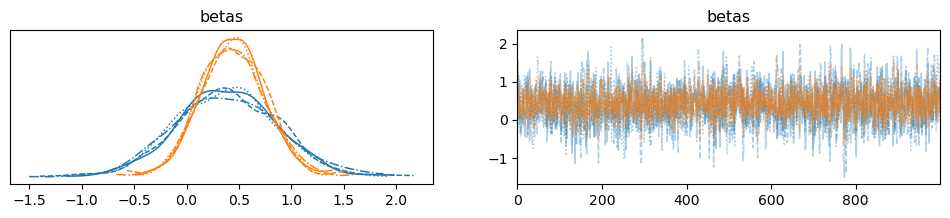

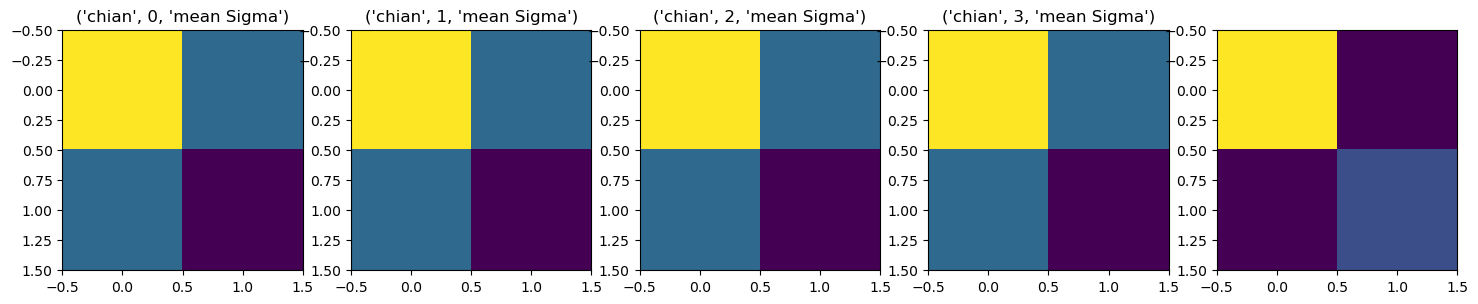

In [31]:
az.plot_trace(idata2,var_names='betas');
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov2)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata2.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(("chian",chain,"mean Sigma"))

# Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Set 0: n=20, p=3, m=3
predictors = ['DewPointAvgF', 'WindAvgMPH', 'SeaLevelPressureAvgInches']
targets = ['TempHighF', 'TempAvgF', 'TempLowF']

Set 1: n=30, p=2, m=2
predictors1 = ['DewPointAvgF', 'WindAvgMPH']
targets1 = ['TempHighF', 'TempLowF']

Set 2: n=20, p=1, m=2
predictors2 = ['DewPointAvgF']
targets2 = ['TempHighF', 'TempLowF']

Set 0
* largest model: slowest convergence
* betas[0,0] = 0.363 +- 0.426: small positive impact of DewPointAvgF on TempHighF
* betas[1,2] = -0.331 +- 0.546: small negative impact of WindAvgMPH on TempLowF.

Set 1
* Increasing n improved parameter estimation, reducing uncertainty.
* all models show strong correlation (Sigma) but larger n=30
* betas[0,0] = 0.402 +- 0.617: slightly larger impact than Set 0

Set 2
* smallest model: fastest convergence but higher posterior uncertainty
* betas[0,0]=0.385+-0.489
* betas[0,1] = 0.440 +- 0.312: small positive impact of DewPointAvgF and TempLowF.

Betas
* all sets show weak/moderate positive relationships between DewPointAvgF and temperature
* higher n reduces uncertainty in betas (smaller SDs in Set 1)
* reducing p (Set 2) increases betas variability in the remaining Betas 

MCMC
* Set 0: ESS>2200, Set 1: ESS>2000, Set 2: ESS>1700
* Set 0 includes more predictors=3: lower posterior uncertainty - higher ESS means MC explores parameter space more efficinetly
* Set 1 has more data n=3: more data -> higher ESS
* Set 2 has low p and n so lower value of ESS

r_hat
* r_hat for all is 1.0 indicating they have all converged

MCSE
* mcse values are low for all models - stable posterior estimates

Interpretation with plots
* posterior distribution of set0: more variation across betas - different predictors contribute uniquely and more variably (-3 to 3)
* posterior distribution of set 2 is the simplest - betas are more concentrated (trace ranging from -1.5 to 1.5)

Heat Maps
* higher m (more targets) introduces more structure into cov matrix - more informative


### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [57]:
df3 = pd.read_csv('student-mat.csv')

# Set 0

In [3]:
df3 = pd.read_csv('student-mat.csv')
targets = ['G1', 'G3']
df3[targets] = (df3[targets] >= 10).astype(int)
predictors = ['studytime', 'failures', 'absences']

X = df3[predictors].values.astype(float)
y = df3[targets].values.astype(int)       

X = (X - X.mean(axis=0)) / X.std(axis=0)

n = 100
X = X[:n]  
y = y[:n]
p = X.shape[1] #p=3
m = y.shape[1] #m=2

with pm.Model() as GLM1:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    # Latent variable for dependency structure
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    
    z = pm.MvNormal('z', mu=X @ betas, chol=L, shape=(n, m))
    
    y_obs = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)
    
    idata3 = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 532 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2063 divergences after tuning. Increase `target_accept` or reparameterize.


In [4]:
az.summary(idata3, var_names='betas')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.252,0.291,-0.287,0.830,0.014,0.009,455.0,507.0,1.01
"betas[0, 1]",-0.039,0.297,-0.593,0.528,0.015,0.010,407.0,414.0,1.01
"betas[1, 0]",-1.199,0.423,-2.006,-0.448,0.027,0.013,236.0,475.0,1.02
"betas[1, 1]",-0.790,0.393,-1.542,-0.092,0.026,0.017,249.0,292.0,1.01
"betas[2, 0]",0.028,0.363,-0.663,0.680,0.019,0.013,361.0,337.0,1.01
"betas[2, 1]",-0.268,0.341,-0.909,0.356,0.016,0.012,453.0,270.0,1.01


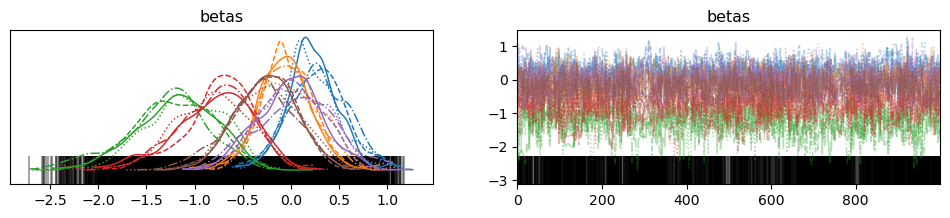

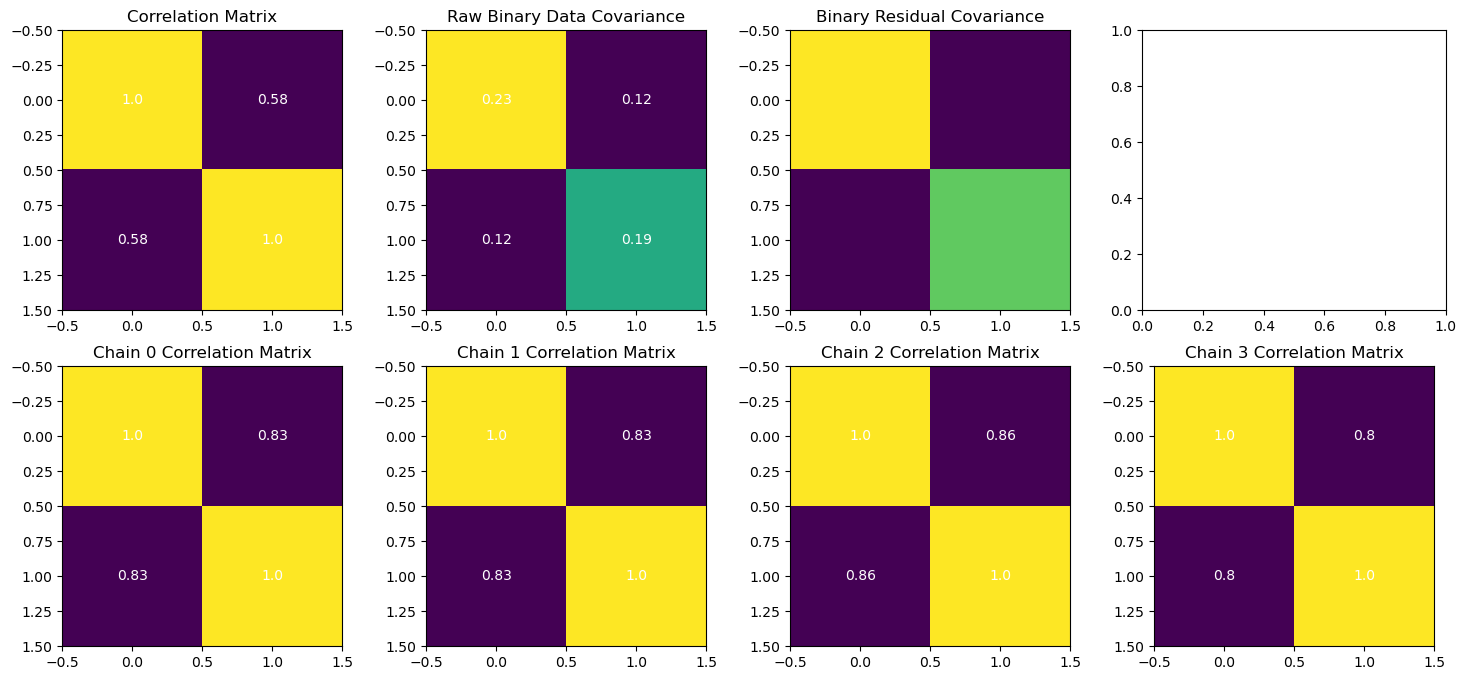

In [44]:
az.plot_trace(idata3,var_names='betas');

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

corr_matrix = np.corrcoef(y.T)
corr_matrix = np.nan_to_num(corr_matrix)
ax[0, 0].imshow(corr_matrix)
ax[0, 0].set_title("Correlation Matrix")
for i in range(m):
    for j in range(m):
        ax[0, 0].text(i, j, str(round(corr_matrix[j, i], 2)), c='w', ha='center', va='center')

ax[0, 1].imshow(np.cov(y.T))
ax[0, 1].set_title("Raw Binary Data Covariance")
for i in range(m):
    for j in range(m):
        ax[0, 1].text(i, j, str(round(np.cov(y.T)[j, i], 2)), c='w', ha='center', va='center')

ax[0, 2].imshow(np.cov((y - stats.norm.cdf(X @ idata3.posterior['betas'].mean(dim=("chain", "draw")).values)).T))
ax[0, 2].set_title("Binary Residual Covariance")

for chain in range(4):
    L_packed_np = idata3.posterior['packed_L'].mean(dim=['draw']).isel(chain=chain).values
    L_packed_np = np.asarray(L_packed_np, dtype=float).flatten()

    L_matrix = pm.expand_packed_triangular(m, L_packed_np).eval()
    R_corr_mean = L_matrix @ L_matrix.T

    D_inv = np.diag(1 / np.sqrt(np.diag(R_corr_mean)))
    R_corr_final = D_inv @ R_corr_mean @ D_inv

    ax[1, chain].imshow(R_corr_final)
    for i in range(m):
        for j in range(m):
            ax[1, chain].text(i, j, str(round(R_corr_final[j, i], 2)), c='w', ha='center', va='center')
    ax[1, chain].set_title(f"Chain {chain} Correlation Matrix")

plt.show()


# Set 1

In [64]:
df3 = pd.read_csv('student-mat.csv')
targets = ['G1', 'G2', 'G3']
df3[targets] = (df3[targets] >= 10).astype(int)
predictors = ['studytime', 'failures', 'absences', 'freetime']

X = df3[predictors].values.astype(float)
y = df3[targets].values.astype(int)       

X = (X - X.mean(axis=0)) / X.std(axis=0)

n = 50
X = X[:n]  
y = y[:n]
p = X.shape[1] #p=4
m = y.shape[1] #m=3

In [65]:
with pm.Model() as GLM0:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    # Latent variable for dependency structure
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    
    z = pm.MvNormal('z', mu=X @ betas, chol=L, shape=(n, m))
    
    y_obs = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)
    
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 591 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2857 divergences after tuning. Increase `target_accept` or reparameterize.


In [67]:
az.summary(idata, var_names='betas')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.563,0.446,-0.220,1.460,0.022,0.014,422.0,641.0,1.01
"betas[0, 1]",0.095,0.519,-0.913,1.000,0.030,0.018,303.0,503.0,1.01
"betas[0, 2]",-0.084,0.516,-1.065,0.839,0.024,0.017,474.0,465.0,1.01
"betas[1, 0]",-1.332,0.645,-2.536,-0.151,0.057,0.054,182.0,76.0,1.02
"betas[1, 1]",-1.497,0.614,-2.703,-0.396,0.026,0.016,567.0,778.0,1.01
"betas[1, 2]",-0.664,0.518,-1.668,0.233,0.027,0.018,343.0,700.0,1.01
"betas[2, 0]",-0.271,0.563,-1.369,0.770,0.027,0.022,448.0,354.0,1.01
"betas[2, 1]",0.098,0.630,-1.042,1.296,0.030,0.018,433.0,648.0,1.01
"betas[2, 2]",-0.632,0.631,-1.802,0.492,0.034,0.017,348.0,603.0,1.01
"betas[3, 0]",0.413,0.381,-0.266,1.167,0.020,0.016,349.0,479.0,1.02


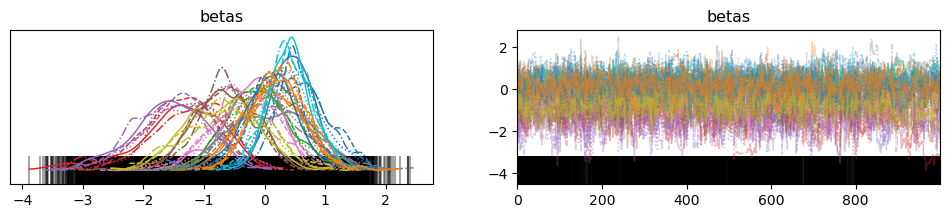

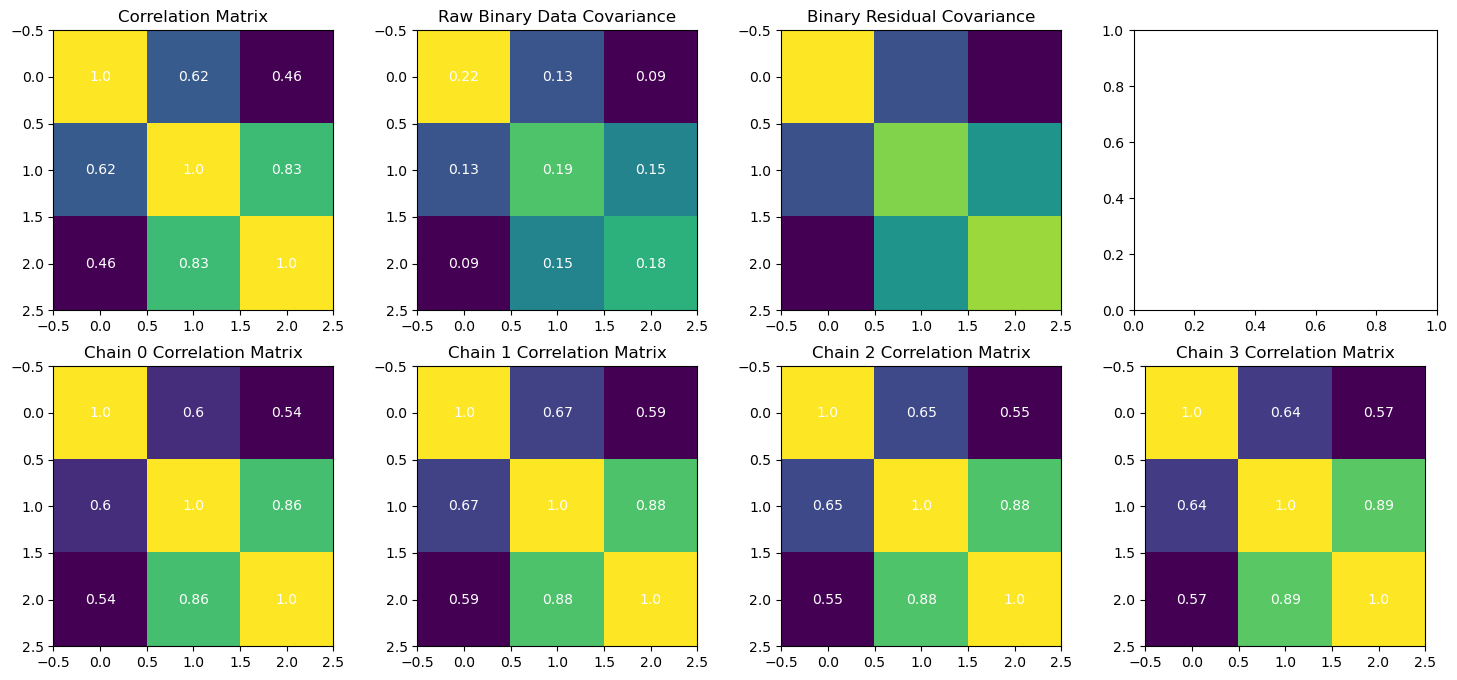

In [66]:
az.plot_trace(idata, var_names='betas')

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

corr_matrix = np.corrcoef(y.T)
corr_matrix = np.nan_to_num(corr_matrix)
ax[0, 0].imshow(corr_matrix)
ax[0, 0].set_title("Correlation Matrix")
for i in range(m):
    for j in range(m):
        ax[0, 0].text(i, j, str(round(corr_matrix[j, i], 2)), c='w', ha='center', va='center')

ax[0, 1].imshow(np.cov(y.T))
ax[0, 1].set_title("Raw Binary Data Covariance")
for i in range(m):
    for j in range(m):
        ax[0, 1].text(i, j, str(round(np.cov(y.T)[j, i], 2)), c='w', ha='center', va='center')

beta_mean = idata.posterior['betas'].mean(dim=("chain", "draw")).values
ax[0, 2].imshow(np.cov((y - stats.norm.cdf(X @ beta_mean)).T))
ax[0, 2].set_title("Binary Residual Covariance")

for chain in range(4):
    L_packed_np = idata.posterior['packed_L'].mean(dim=['draw']).isel(chain=chain).values
    L_packed_np = np.asarray(L_packed_np, dtype=float).flatten()

    L_matrix = pm.expand_packed_triangular(m, L_packed_np).eval()
    R_corr_mean = L_matrix @ L_matrix.T

    D_inv = np.diag(1 / np.sqrt(np.diag(R_corr_mean)))
    R_corr_final = D_inv @ R_corr_mean @ D_inv

    ax[1, chain].imshow(R_corr_final)
    for i in range(m):
        for j in range(m):
            ax[1, chain].text(i, j, str(round(R_corr_final[j, i], 2)), c='w', ha='center', va='center')
    ax[1, chain].set_title(f"Chain {chain} Correlation Matrix")

plt.show()


### Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Predictors and Data Differences
* Set 0: n=100, p=3, m=2
* Set 1: n=50, p=4, m=3

Summary
* set 1 has more significant values for betas
* stronger predictor influence
* also has larger variance
* also has higher MCSE - more variable
* Set 1 has lower ESS for some parameters
* all r_hat is 1.01-1.02: convergence is fine

Matrix
* correlations between G1/G3 are lower in Set 0
* set 1 has higher cov in raw binary data cov - more variance
* set 1 has higher correlations across chains 
* set 1 has stronger predictor effects on targets (grades)